# **Análise do NDVI em áreas de Pivôs de Irrigação utilizando imagens dos satélites Sentinel 2 e Landsat 8.**

Importação das bibliotecas:
Google Earth Engine API e Rasterio

In [ ]:
!pip install ipygee
!pip install earthengine-api
!pip install rasterio
!pip install geetools

Autenticação do GEE, utilizado como fonte de obtenção dos dados geoespaciais.

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=8w6xunIzzwcDmH_ozgUZgiWB5rKBQDa_OypvQrCSM3U&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7neDfOAuM6usp-nmGesCO7DKkwpDTTMUPYvr1H_L70WUfcR4WqVjY

Successfully saved authorization token.


Autenticação do Google Drive, que será utilizado como apoio no armazenamento das imagens.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importação das bibliotecas de auxílio, como o Folium para visualização de mapas, o pandas e o numpy para manipulação de dados, etc.

In [ ]:
import folium
from folium import plugins
from IPython.display import Image
from ipygee import*
import geetools
import rasterio
import pandas as pd
import numpy as np
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 18, 8

Obtenção da área de interesse armazenada na plataforma em javascript do Google Earth Engine e seleção dos pontos de análise para vegetação saudável e solo exposto.

In [ ]:
AOI = ee.FeatureCollection('users/joaootavionf007/sorriso-mt')
vegetacao_saudavel = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Point([-55.5321124493307, -12.913555209315836]),
            {
              "system:index": "0"
            })]);
solo_exposto = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Point([-55.517012149455255, -12.940069136041117]),
            {
              "system:index": "0"
            })]);

Obtenção das imagens do satélite Sentinel 2 para área de estudo nas datas pré-definidas.

In [ ]:
startDateviz = ee.Date.fromYMD(2020,1,1);
endDateviz = ee.Date.fromYMD(2020,6,30);
collectionviz = ee.ImageCollection("COPERNICUS/S2").filterDate(startDateviz,endDateviz).filterBounds(AOI).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 0.1);

Utilização do filtro de mediana para geração de uma imagem a partir da coleção de imagens.

In [ ]:
S2 = collectionviz.median().clip(AOI).divide(10000)
vis_params = {'min': 0, 'max': 0.4, 'bands': ['B4', 'B3','B2']}

Aritmética de bandas para a obtenção do NDVI.

In [ ]:
NDVI = S2.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndvi_params = {'min': 0, 'max': 0.8, 'palette': ['red', 'yellow','green']}

In [ ]:
basemaps = {
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    )}

In [ ]:
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [ ]:
my_map = folium.Map(location=[-12.951701203998772,-55.54069551817835], zoom_start=13)

# Add custom basemaps
basemaps['Google Terrain'].add_to(my_map)

# Add the elevation model to the map object.
my_map.add_ee_layer(S2, vis_params, 'Sentinel 2')
my_map.add_ee_layer(NDVI, ndvi_params, 'NDVI')
my_map.add_ee_layer(vegetacao_saudavel.geometry(), {}, 'Vegetação Saudável')
my_map.add_ee_layer(solo_exposto.geometry(), {}, 'Solo Exposto')
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

# Assinatura espectral de um pixel com vegetação saudável e de solo exposto.

In [ ]:
points = ee.FeatureCollection([
  ee.Feature(ee.Geometry.Point(-55.5321124493307, -12.913555209315836), {'label': 'Vegetação Saudável'}),
  ee.Feature(ee.Geometry.Point(-55.517012149455255, -12.940069136041117), {'label': 'Solo exposto'}),
]);

In [ ]:
Bands_S2 = ['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12']

In [ ]:
S2 = S2.select(Bands_S2)

In [ ]:
S2 = S2.addBands(NDVI)

In [ ]:
Bandsx = ['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'NDVI']

In [ ]:
chart_band = chart.Image.bandsByRegion(**{
    'image': S2, 
    'collection': points,
    'reducer': 'mean',
    'scale': 10,
    'bands': Bandsx,
    'labels': Bandsx
})

In [ ]:
df = chart_band.dataframe

In [ ]:
colunas = ['bandas' , 'valores', 'tipo']
bandas = df.columns.append(df.columns)
valores = df.values.flatten()
tipo = ['Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável','Vegetação Saudável',
        'Solo exposto','Solo exposto','Solo exposto','Solo exposto','Solo exposto','Solo exposto','Solo exposto','Solo exposto','Solo exposto','Solo exposto','Solo exposto','Solo exposto','Solo exposto','Solo exposto']

In [ ]:
new_df = pd.DataFrame(data = np.vstack((bandas,valores,tipo)).transpose(), columns=colunas)

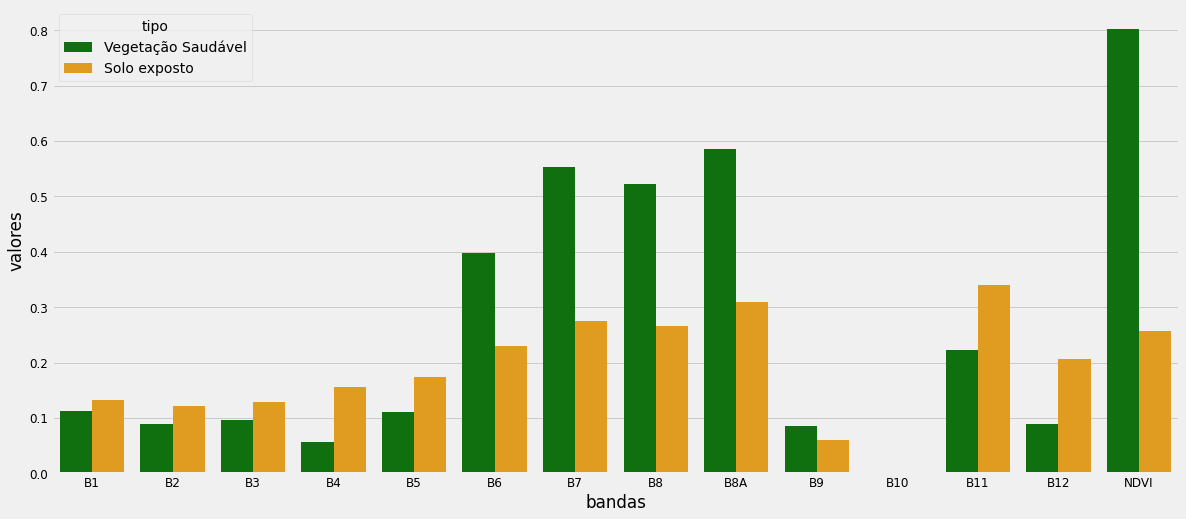

In [ ]:
ax = sns.barplot(x="bandas", y="valores", hue="tipo", data=new_df,  palette=["green", "orange"])

O Gráfico acima demonstra os valores de reflectância num range entre 0 e 1 da bandas do satélite Sentinel 2 junto ao NDVI para os dois pontos selecionados. Note que os valores de reflectância da vegetação saudável são menores na faixa do visível, tornam se maiores no infravermelho próximo e volta a serem menores no infravermelho média, se comparado aos valores de solo exposto. A figura Abaixo representa os dados obtidos.

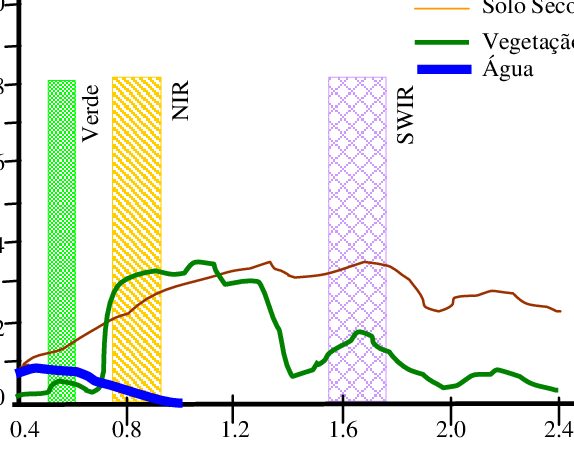

# Matriz NDVI de valores:

In [ ]:
task = ee.batch.Export.image.toDrive(image=NDVI, 
                                         crs='EPSG:4326',
                                         scale=10, 
                                         fileFormat='GeoTIFF',
                                         description='NDVI' ,
                                         maxPixels=1e13,
                                         region= AOI.geometry())

In [ ]:
task.start()

In [ ]:
path = 'drive/My Drive/NDVI.tif'

In [ ]:
with rasterio.open(path) as src:
    im = src.read()

Representação da imagem NDVI como uma matriz de valores numéricos:

In [ ]:
print(im)

[[[0.4620764  0.50161815 0.5052039  ... 0.6191547  0.60651976 0.60651976]
  [0.46155232 0.509094   0.52088577 ... 0.6110972  0.5957768  0.5957768 ]
  [0.44405913 0.49965397 0.5215311  ... 0.5978447  0.59329253 0.59329253]
  ...
  [0.31014577 0.308286   0.30431023 ... 0.38958707 0.39233676 0.40085137]
  [0.30082476 0.30938822 0.3041088  ... 0.38967973 0.3917691  0.39161462]
  [0.30010173 0.30202124 0.3086384  ... 0.37125534 0.39260313 0.4008889 ]]]


# Série Temporal de NDVI

Seleção de uma coleção de imagens do satélite Sentinel 2 com uma porcentagem de nuvens menor que 25%.

In [ ]:
TSS2 = ee.ImageCollection("COPERNICUS/S2").filterDate(startDateviz,endDateviz).filterBounds(AOI).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 25);

In [ ]:
S2_NDVI = TSS2.map(lambda image: image.normalizedDifference(['B8', 'B4']).rename('NDVI').copyProperties(image, ['system:time_start']))

In [ ]:
S2_NDVI_chart = chart.Image.series(**{'imageCollection': S2_NDVI,
                                   'region': solo_exposto,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 10,
                                   'xProperty': 'system:time_start'})

In [ ]:
S2_dataframe = S2_NDVI_chart.dataframe

Plotagem da série temporal de NDVI do Sentinel 2

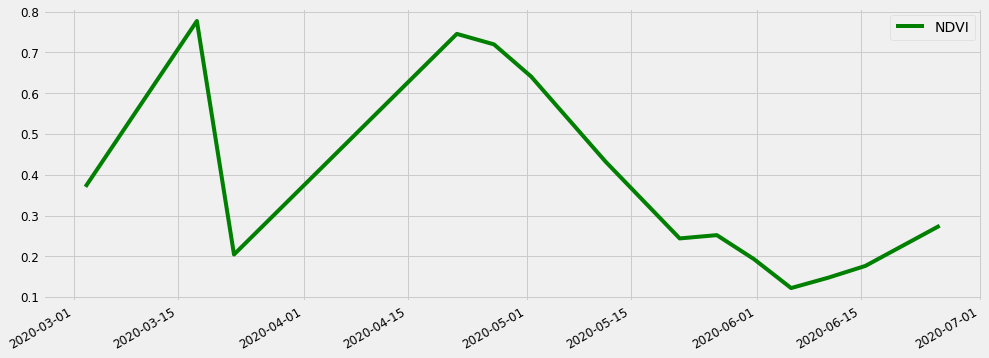

In [ ]:
S2_dataframe.plot(figsize=(15, 6), color='green')
plt.show()

Seleção de imagens do satélite Landsat 8 com uma porcentagem de nuvem menor que 50%.

In [ ]:
TSL8 = ee.ImageCollection("LANDSAT/LC08/C01/T2_TOA").filterDate(startDateviz,endDateviz).filterBounds(AOI).filter(ee.Filter.lt('CLOUD_COVER', 50));

In [ ]:
L8_NDVI = TSL8.map(lambda image: image.normalizedDifference(['B5', 'B4']).rename('NDVI').copyProperties(image, ['system:time_start']))

In [ ]:
L8_NDVI_chart = chart.Image.series(**{'imageCollection': L8_NDVI,
                                   'region': solo_exposto,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 15,
                                   'xProperty': 'system:time_start'})

In [ ]:
L8_dataframe = L8_NDVI_chart.dataframe

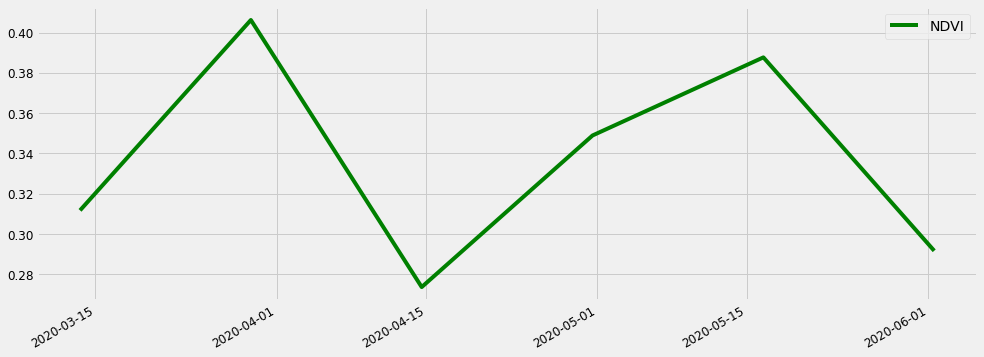

In [ ]:
L8_dataframe.plot(figsize=(15, 6), color='green')
plt.show()

De acordo com as séries temporais obtidas pelos Satélites Landsat 8 e Sentinel 2 e pelo uso do NDVI conforme teorizado na figura abaixo, é possível observar que para o ponto selecionado (Pivo de Irrigação) houve 2 épocas de plantio e colheita da cultura. A Primeira época teve plantio provavelmente no final de 2019 e colheita no fim de abril. Já a segunda época teve plantio no fim de abril de 2020 e colheita no final de março, iniciando um novo ciclo em Junho de 2020.

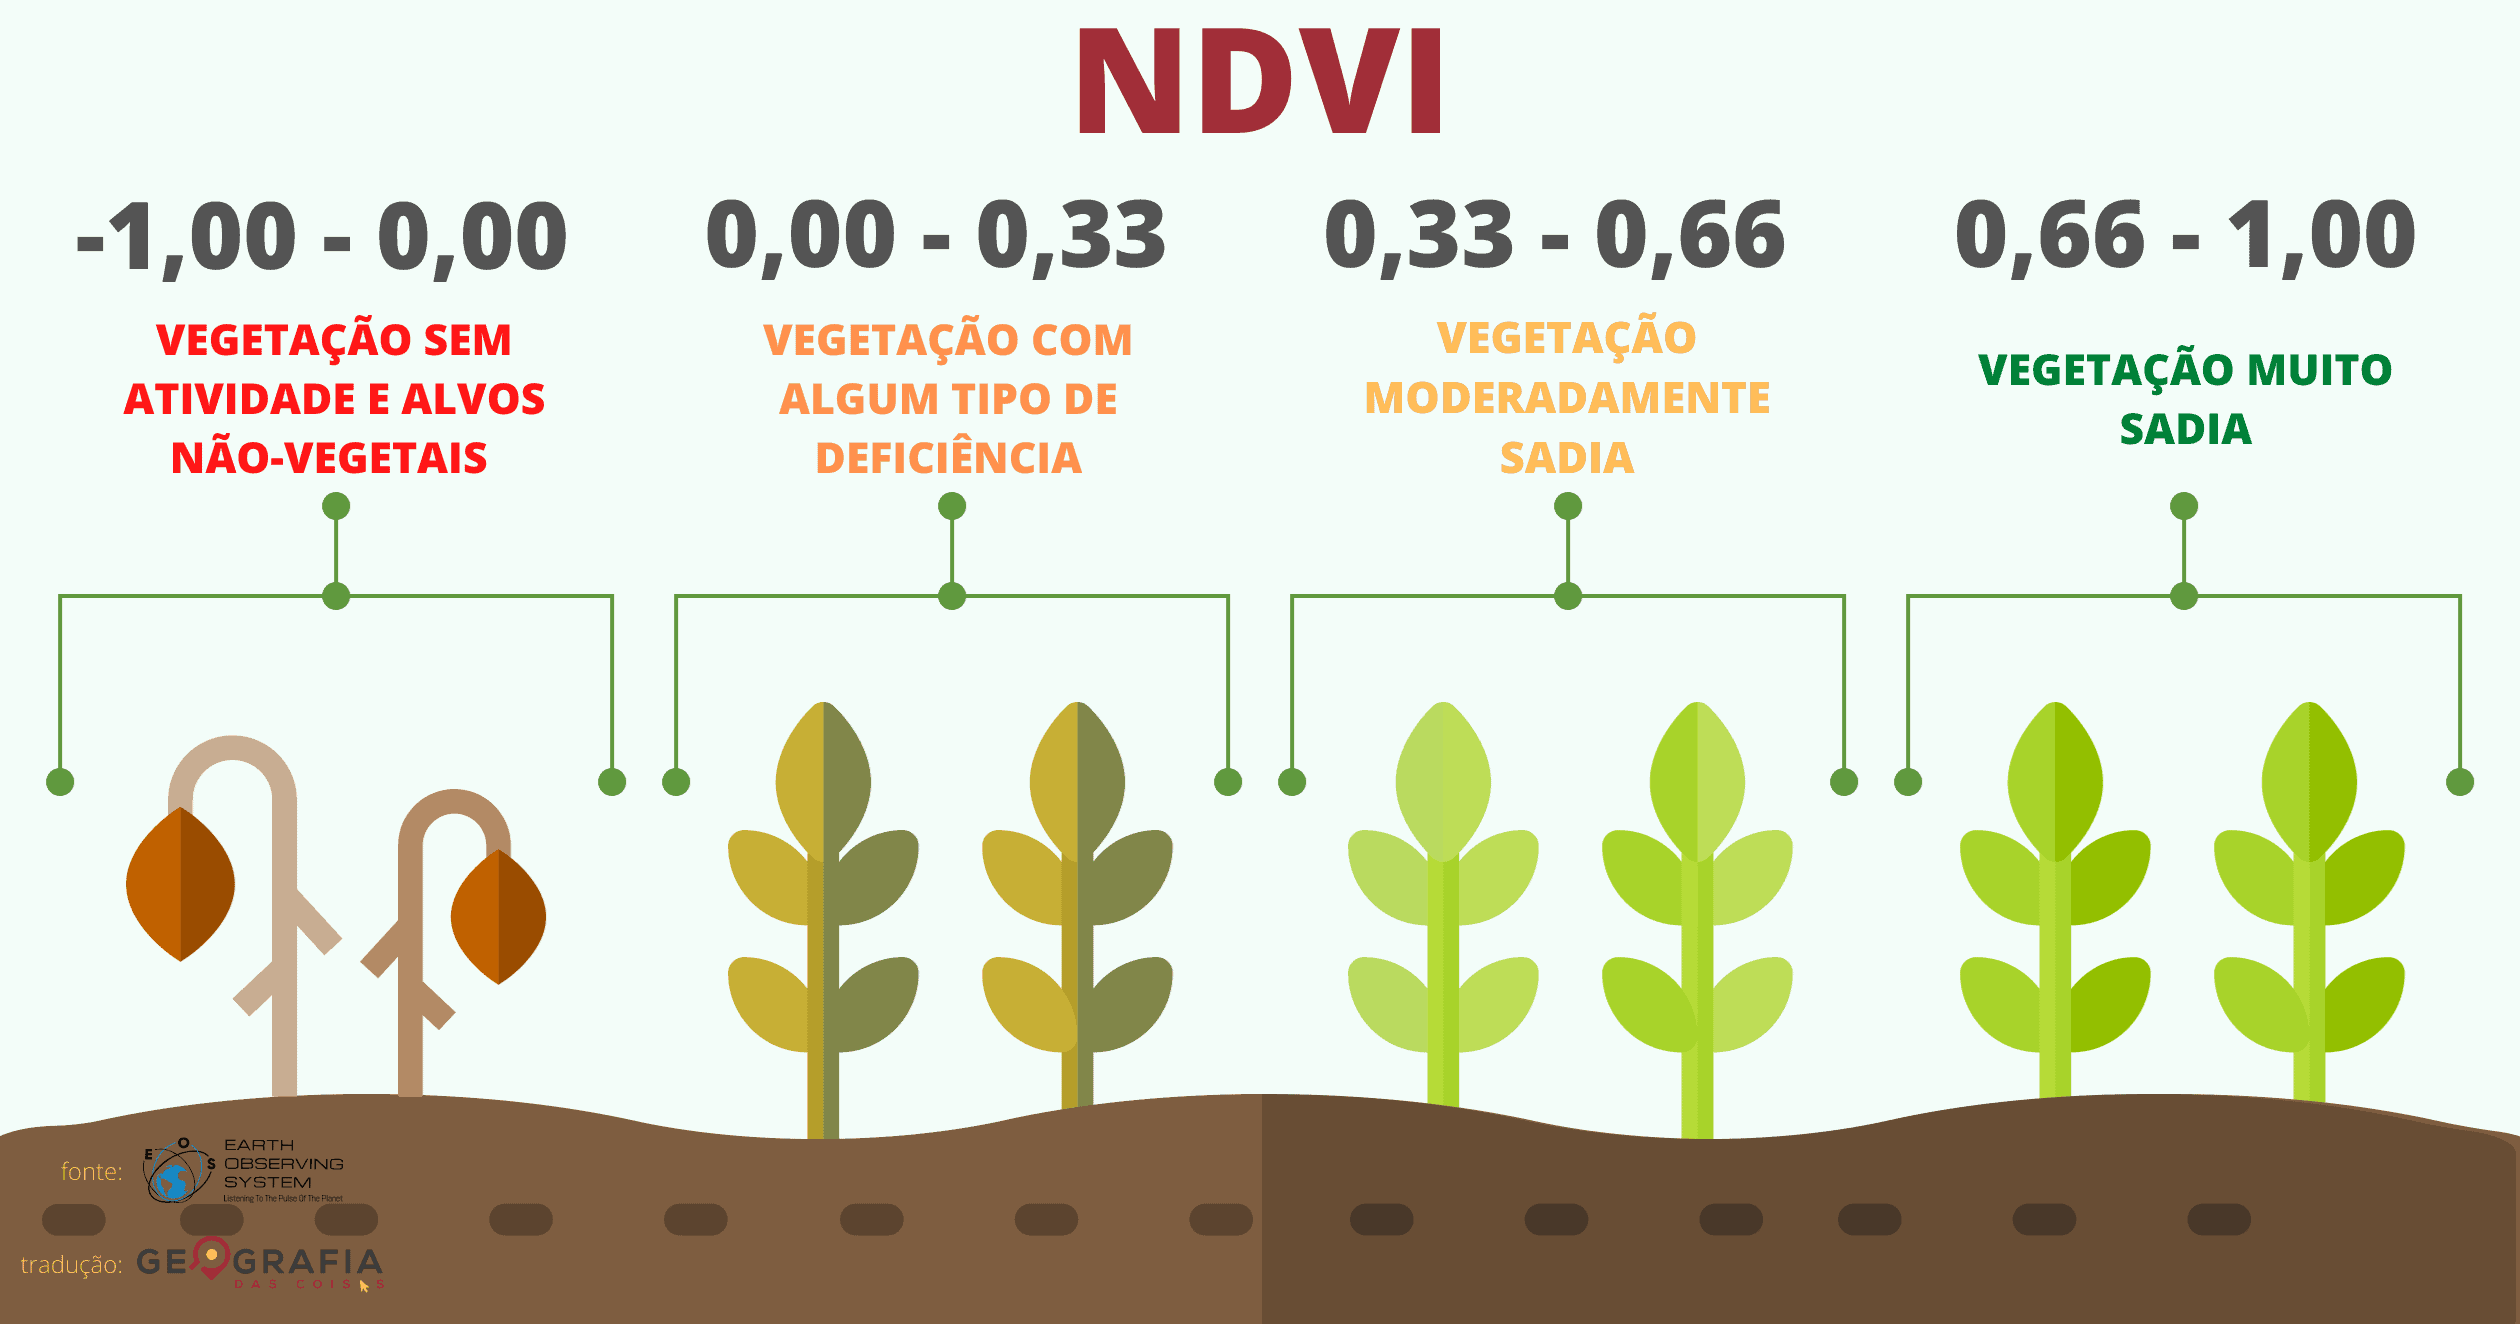

# Donwload em Lote

Para a execução do download em lote foi utilizada uma biblioteca pyhton para o Google Earth Engine, que recebe de entrada a coleção de imagens a serem baixadas, exportando-as para o Google Drive.

In [ ]:
tasks = geetools.batch.Export.imagecollection.toDrive(
            collection=TSS2,
            folder='/gee_files',
            region=AOI,
            scale=20,
            verbose=True,
            maxPixels=int(1e13)
        )

exporting 20200302T140051_20200302T140048_T21LXF to folder '/gee_files' in GDrive
exporting 20200317T140049_20200317T140050_T21LXF to folder '/gee_files' in GDrive
exporting 20200322T140051_20200322T140048_T21LXF to folder '/gee_files' in GDrive
exporting 20200421T140051_20200421T140053_T21LXF to folder '/gee_files' in GDrive
exporting 20200426T140049_20200426T140224_T21LXF to folder '/gee_files' in GDrive
exporting 20200501T140101_20200501T140055_T21LXF to folder '/gee_files' in GDrive
exporting 20200511T140101_20200511T140057_T21LXF to folder '/gee_files' in GDrive
exporting 20200521T140101_20200521T140058_T21LXF to folder '/gee_files' in GDrive
exporting 20200526T140059_20200526T140422_T21LXF to folder '/gee_files' in GDrive
exporting 20200531T140101_20200531T140058_T21LXF to folder '/gee_files' in GDrive
exporting 20200605T140059_20200605T140054_T21LXF to folder '/gee_files' in GDrive
exporting 20200610T140101_20200610T140059_T21LXF to folder '/gee_files' in GDrive
exporting 202006